Math Modelling <br>
Covid-19 Project <br>
Connie Zhou <br>

# Math Modelling Covid-19 Background Information
An SIR model is an epidemiological model that computes the theoretical number of people infected with a contagious illness in a closed population over time. We are able to compartmentalize the population into three categories. S-the number of susceptible population, I-the number of actively infected population, and R-the number of recovered or deceased population.
\begin{eqnarray}
\frac{dS}{dt} &=& -aS\frac{I}{N}\\
\frac{dI}{dt} &=& aS\frac{I}{N} - bI\\
\frac{dR}{dt} &=& bI
\end{eqnarray}
<br>
In 3.7.6 of Strogatz we previously found that the number of fixed points for the SIR model was 1 where $u=u^*$ where we were able to find that u* is a stable point. 

# Project Information
In this project I will be using the SIR model to model current covid-19 data from three U.S. states. I will be modelling data for New York, Utah, and Texas. I chose my states based on the availability of data and tried to pick states that I thought would provide different results. NY has been hit hard in NYC and has shown to have passed its peak. My hometown is Utah and I thought it would be interesting because it has not shown any pattern of approaching a peak. Additionally I knew its rate of infection would most likely be different because it's population density is so much smaller. I chose Texas because it has shown patterns of approaching a peak but not yet hitting it. 
<br><br>
To model the states, I will be using data to estimate the number of susceptible, infected, and recovered population for each day. I will be using the Gauss-Newton method to estimate the growth rate a, and recovery rate b. And then applying the found parameters to the deterministic SIR model where we will be able to see the future trajectories for each state.
<br><br>
In the project I will be collected data of number of recovered, number of deaths, and number of confirmed cases.
<br><br>
To estimate recovered population, I was able to retrieve data about the recovered population. Unfortunately, this data is incomplete and only began being recorded later during the pandemic. Therefore I will be estimating the recovered population for days where the data is missing. I also summed the recovered data with the deaths in this model, so recovered will mean the removed population which will include dead individuals and individuals who have recovered.
<br><br>
To estimate infected population, calculated the number of infections from data of new infections. Since the incubation period is 14 days, I decided to remove infected individuals from the infected population after 14 days of being sick. I found this to be the best estimate as it was difficult to figure out who to remove and when from the removed population data.
<br><br>
To estimate the susceptible population I subtracted the amount of removed and infected population from the total population.

NOTE: In this document I refer to days such as day 50 or day 70 or etc. This refers to the day from after the virus was introduced. For most states this is mid March. I have also displayed the dataframe heads of the cases to allow you to get an idea of when the start day is for each state.

NOTE: When picking population of states. I did not go by the total state population. I adjusted populations to be a fraction of the total population per state. I did this by taking roughly 25% of the population where the majority of cases were coming from. I noticed for many states, the virus was not spread uniformly throughout the state but at urban areas in the state. This was simply because the large populations did not give me accurate parameters when calling GaussIter(). And additionally, the total population is not exposed to the virus. With most people staying home I decided to pick a population that is regularly exposed.


# Importing Libraries and Functions

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import pylab
from scipy.optimize import curve_fit


In [3]:
def smooth_new_cases(new_cases, cutoff=25):
    # The function below does a "Gaussian rolling average" of the data. Basically it smooths out jumps in the data
    # the first argument -- '7' -- is the number of days over which to apply the average, i.e. filtered new_cases(i) 
    # is roughly an average over new_cases(i-3) to new_cases(i+3)
    
    new_cases_smoothed = new_cases.rolling(7, win_type='gaussian', min_periods=1,center=True).mean(std=2).round()
    
    # Ignore data before there are at least 25 new cases in a day
    idx_start = np.searchsorted(new_cases_smoothed, cutoff)     # Finds index where value in smoothed = cutoff
    new_cases_smoothed = new_cases_smoothed.iloc[idx_start:]
    
    return new_cases_smoothed


In [4]:
def smooth_new_cases(new_cases, cutoff=25):
    # The function below does a "Gaussian rolling average" of the data. Basically it smooths out jumps in the data
    # the first argument -- '7' -- is the number of days over which to apply the average, i.e. filtered new_cases(i) 
    # is roughly an average over new_cases(i-3) to new_cases(i+3)
    
    new_cases_smoothed = new_cases.rolling(7, win_type='gaussian', min_periods=1,center=True).mean(std=2).round()
    
    # Ignore data before there are at least 25 new cases in a day
    idx_start = np.searchsorted(new_cases_smoothed, cutoff)     # Finds index where value in smoothed = cutoff
    new_cases_smoothed = new_cases_smoothed.iloc[idx_start:]
    
    return new_cases_smoothed


In [5]:
def SIRdot(Y, t, N, a, b):
    S, I, R = Y
    dSdt = -a * S * I/N 
    dIdt = a * S * I/N  - b * I
    dRdt = b * I
    
    return dSdt, dIdt, dRdt

In [6]:
def SIRsol_with_param_gradients(SIRdot, t, S0, I0, R0, a, b):
    # Compute solution 5 times:  [a, b], [a+da,b], [a-da,b], [a, b+db], [a, b-db]
    # Then compute gradient wrt a, b, at each t
    Y0 = S0, I0, R0
    N = S0+I0+R0
    da = a/10
    db = b/10
    
    sol = odeint(SIRdot, Y0, t, args=(N, a, b))
    S, I, R = sol.T
    

    sol = odeint(SIRdot, Y0, t, args=(N, a+da, b))
    Sap, Iap, Rap = sol.T
 
    sol = odeint(SIRdot, Y0, t, args=(N, a-da, b))
    Sam, Iam, Ram = sol.T

    sol = odeint(SIRdot, Y0, t, args=(N, a, b+db))
    Sbp, Ibp, Rbp = sol.T
 
    sol = odeint(SIRdot, Y0, t, args=(N, a, b-db))
    Sbm, Ibm, Rbm = sol.T

    dIda = (Iap-Iam)/(2*da)
    dIdb = (Ibp-Ibm)/(2*db)
    
    
    #return S, I, R, dIda, dIdb
    return I, dIda, dIdb, S

In [7]:
def GaussIter(t, Idata, S0, I0, R0, a0, b0):
    tol = .01
    NiterMax = 50
    
    a, b = a0, b0
    Da, Db = 1, 1
    
    fig = plt.figure(facecolor='w')
    plt.plot(t, Idata, 'b.', label='Data')
    
    Niter = 0
    while np.sqrt((Da)**2+(Db)**2) > tol and Niter < NiterMax:
        Niter += 1
        It, dIda, dIdb, St = SIRsol_with_param_gradients(SIRdot, t, S0, I0, R0, a, b)
        DI = Idata-It
        J = np.vstack((dIda,dIdb)).T
        
        Da,Db = np.linalg.inv(J.T.dot(J)).dot(J.T.dot(DI))
        a = a+Da
        b = b+Db
        
        plt.plot(t, It, alpha=0.5, lw=2, label='Model fit')
        
    plt.xlabel('Time /days')
    plt.ylabel('Infected population')
    plt.grid()
    plt.legend()
    return It, a, b, Niter, dIda, dIdb, St

# Collecting Data for U.S. States
In this project I will be using data of cases and recovered individuals from covidtracking.com's api.
<br><br>
The information I am collecting for each state is number of confirmed cases per day, recovered individuals per day, and deaths per day. 

In [8]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'   

states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive'], # grab only these columns from CSV
                     parse_dates=['date'],                  # .. confusing 
                     index_col=['state', 'date'],           # use these as column labels
                     squeeze=True).sort_index()             # sort the data 

states_rec = pd.read_csv(url,
                     usecols=['date', 'state', 'recovered'], # grab only these columns from CSV
                     parse_dates=['date'],                  # .. confusing 
                     index_col=['state', 'date'],           # use these as column labels
                     squeeze=True).sort_index()             # sort the data 

states_death = pd.read_csv(url,
                     usecols=['date', 'state', 'death'], # grab only these columns from CSV
                     parse_dates=['date'],                  # .. confusing 
                     index_col=['state', 'date'],           # use these as column labels
                     squeeze=True).sort_index()             # sort the data 

In [378]:
nycases = states.xs("NY")
utcases = states.xs("UT")
txcases = states.xs("TX")

nyrec = states_rec.xs("NY")
utrec = states_rec.xs("UT")
txrec = states_rec.xs("TX")

nydeaths = states_death.xs("NY")
utdeaths = states_death.xs("UT")
txdeaths = states_death.xs("TX")

nydeathlist=nydeaths.fillna(0).values.tolist()
utdeathlist=wadeaths.fillna(0).values.tolist()
txdeathlist=wadeaths.fillna(0).values.tolist()

In [379]:
nycases.head()


date
2020-03-04      6.0
2020-03-05     22.0
2020-03-06     33.0
2020-03-07     76.0
2020-03-08    105.0
Name: positive, dtype: float64

In [380]:
utcases.head()


date
2020-03-07    1.0
2020-03-08    1.0
2020-03-09    1.0
2020-03-10    2.0
2020-03-11    2.0
Name: positive, dtype: float64

In [381]:
txcases.head()

date
2020-03-04    1.0
2020-03-05    1.0
2020-03-06    5.0
2020-03-07    8.0
2020-03-08    8.0
Name: positive, dtype: float64

# New York Modelling

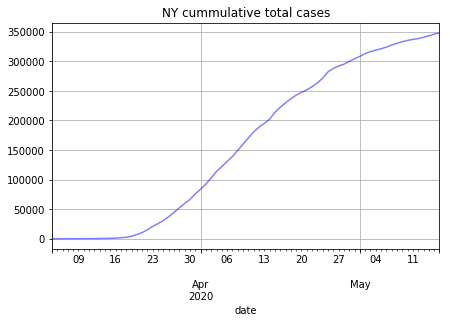

In [382]:
nycases.plot(title="NY cummulative total cases",
            c='b',
            alpha=.5,
            grid=True,
            figsize=(500/72, 300/72))

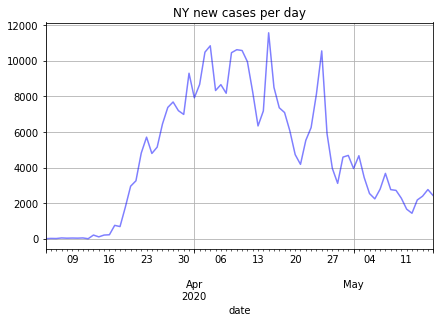

In [383]:
nynew_cases = nycases.diff().fillna(1)   # compute the number of new cases per day:  basically,
                           # new_cases(i) = cases(i)-cases(i-1), and then new_cases(0) = NaN
    

nynew_cases.plot(title="NY new cases per day",
               c='b',
               alpha=.5,
               grid=True,
               figsize=(500/72, 300/72))

# Estimating NY Infected, Susceptible, and Recovered
Here I was able to estimate the number recovered by fitting a sigmoid curve to the recovered population. From here I was able to estimate the susceptible population, and the infected population.

One observation to make is that using the NY state population of 19 Million, I was unable to get accurate parameters. I ended up adjusting the population which allowed me to extract the parameters and get a better result. This is also because I felt as though not all 19 million of the population were exposed. The majority of the cases were in NYC and NYC quickly went into lockdown after the virus was introduced. This further reduced the population exposed to the virus

In [438]:
#Setting population and lists for susceptible, infected, and recovered

N=200000

Sd=[]
Id=[]
Rd=[]

[ 2709.7840243   3327.12067066  4021.02958847  4798.60326971
  5666.91939144  6632.82874272  7702.69354721  8882.07720893
 10175.391332   11585.51200808 13113.38448127 14757.64267586
 16514.27660234 18376.38491426 20334.05033157 22374.3709635
 24481.67009981 26637.89119625 28823.16523075 31016.51718477
 33196.66060496 35342.81739158 37435.4965051  39457.17089212
 41392.80545764 43230.20767177 44960.19291738 46576.57555957
 48076.01136434 49457.72595172 50723.16731948 51875.61897288
 52919.80524711 53861.51355427 54707.25088636 55463.94497524
 56138.69466675 56738.56958018 57270.45600279 57740.94405644
 58156.25023356 58522.16917909 58844.04886042 59126.78382595
 59374.82195746 59592.18086755 59782.4708138  59948.92165565
 60094.41194947 60221.4987568 ]
-1344.79394471886


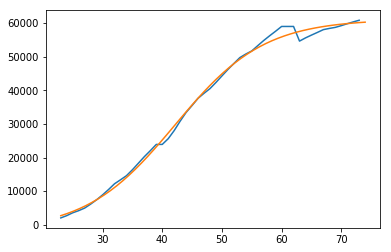

In [439]:
#estimate recovered population using sigmoid curve

#nyrec.plot()
xdata=np.arange(23,len(nycases))
temp=nyrec.values.tolist()
ydata=temp[23:]

plt.plot(xdata,ydata)

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)


p0 = [max(ydata), np.median(xdata),1,min(ydata)]
popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')


x = np.linspace(23,len(nycases))
y = sigmoid(x, *popt)

print(y)
rec0=sigmoid(5,*popt)
print(rec0)

plt.plot(x,y)

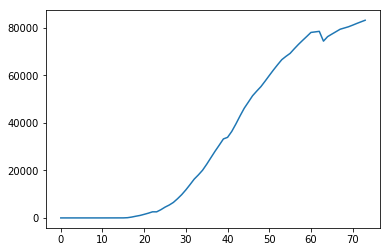

In [440]:
#Get values for estimated recovered and add to Rd as well as calculating in the deaths

prev_vals=np.arange(0,23,1)
rec=sigmoid(prev_vals,*popt)
rec=rec.tolist()
#ylist=y.tolist()
#print(ydata)
rec.extend(ydata)
#print(rec)
x=np.arange(len(nycases))
#print(x)

removed=[]

#print(len(nydeathlist))
#print(len(rec))
for i in range(0,len(rec)):
    if rec[i]<0:
        rec[i]=0

for i in range(0,len(rec)):
    removed.append(rec[i]+nydeathlist[i])

#print(rec)
#print(removed)
Rd=rec
plt.plot(x,removed)

In [441]:
activeCases=[]
#estimating infected population
for i in range(len(nynew_cases)):
    if len(activeCases)>14:
        activeCases.pop(0)
        
    activeCases.append(nynew_cases[i])
    Id.append(sum(activeCases))

In [442]:
#Estimating susceptible population

for i in range(0,len(nycases)):
    Sd.append(N-Id[i]-Rd[i])

(0.44855528522615756, 0.031129003986472174, 5)

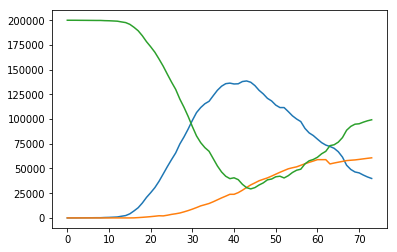

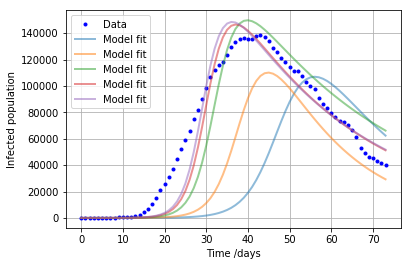

In [443]:
#Getting growth and recovered rate
import scipy.optimize

a0 = .3 #estimation for now
b0 = .05 #estimation for now


R0=Rd[0]   
S0=Sd[0]
I0=Id[0]
t=np.arange(len(nycases))


plt.plot(t,Id,label="Infected")
plt.plot(t,Rd,label="Recovered")
plt.plot(t,Sd,label="Suceptible")


It, at, bt, Niter, dIda, dIdb, St = GaussIter(t, Id, S0, I0, R0, a0, b0)
#params,pcov=curve_fit(It, t, Id, p0=[a0,b0],bounds=([0.0,0.0],[5.0,5.0]))
at, bt, Niter

# NY Model Analysis

Now that we have extracted our growth rate a and recovery rate b, we can apply our findings to a deterministic SIR model.

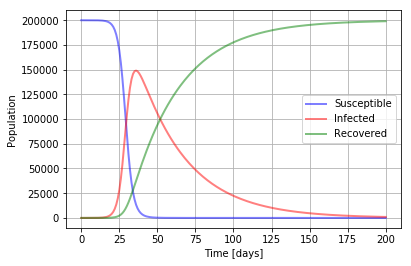

In [444]:
# Total population, N.

I0 = Id[0]
R0 = Rd[0]
S0 = Sd[0]

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
a = at
b = bt

# A grid of time points (in days)
T = 200
dt = 1
Nt = np.int(T/dt)+1
t = np.linspace(0, T, Nt)

# Initial conditions vector
Y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t.
sol = odeint(SIRdot, Y0, t, args=(N, a, b))
S, I, R = sol.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
plt.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')
plt.xlabel('Time [days]')
plt.ylabel('Population')
plt.grid() 
plt.legend()


# Summary

By applying our parameters to the SIR model we can make several observations. One being that the peak occurs around day 35-40. If we compare the the chart of new cases in NY, we can see that the peak was also around that time frame. Another thing to note is that naturally the virus would take around 175-200 days to resolve itself. This would be due to the majority of individuals contracting the virus and either recovering or dying. Our growth rate a ended up being very high, around .44 with a low recovery rate of 0.03. This is believable because the virus as shown to be less deadly than many other pandemics and the virus has shown to spreading very rapidly in NYC, especially due to the reliance on public transportation such as the subway. Additionally the reported amount of recovered individuals is underreported. Some quick research on covidtracker.com mentioned that the number of recovered individuals came from the number of discharged patients from hospitals. Not all infected individuals when to hospitals which is why that data is a bit skewed.

# Utah Modelling

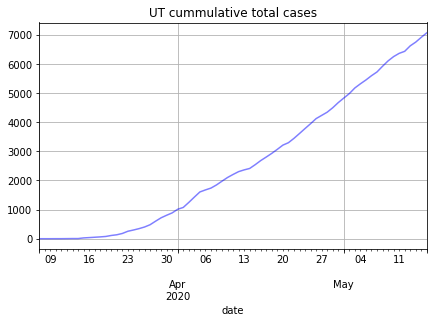

In [391]:
utcases.plot(title="UT cummulative total cases",
            c='b',
            alpha=.5,
            grid=True,
            figsize=(500/72, 300/72))

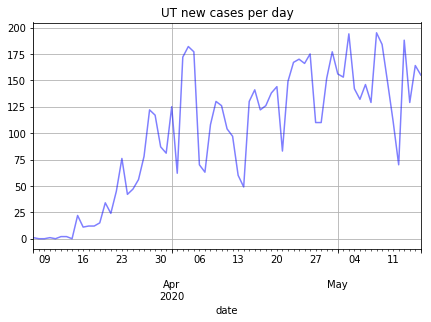

In [392]:
utnew_cases = utcases.diff().fillna(1)   # compute the number of new cases per day:  basically,
                           # new_cases(i) = cases(i)-cases(i-1), and then new_cases(0) = NaN
    

utnew_cases.plot(title="UT new cases per day",
               c='b',
               alpha=.5,
               grid=True,
               figsize=(500/72, 300/72))

# Estimating UT Infected, Susceptible, and Recovered


In [411]:
#Setting population and lists for susceptible, infected, and recovered

N=10000

Sd=[]
Id=[]
Rd=[]

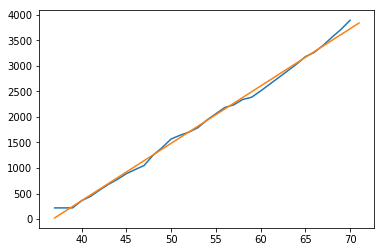

In [412]:
#estimate recovered population using sigmoid curve
xdata=np.arange(37,len(utrec))
temp=utrec.values.tolist()
ydata=temp[37:]



plt.plot(xdata,ydata)

coefficients = np.polyfit(xdata, ydata, 1)
poly = np.poly1d(coefficients)

new_x = np.linspace(37,len(utrec))
new_y = poly(new_x)
plt.plot(new_x,new_y)


#x = np.linspace(37,len(utrec))
#y = sigmoid(x, *popt)

#print(y)
#rec0=sigmoid(5,*popt)
#print(rec0)

#plt.plot(x,y)

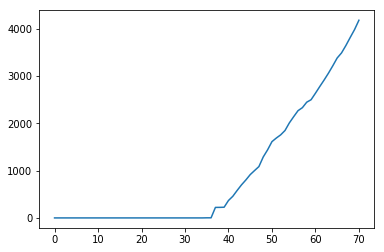

In [413]:
#Get values for estimated recovered and add to Rd as well as calculating in the deaths

prev_vals=np.arange(0,37,1)
rec=poly(prev_vals)
rec=rec.tolist()
#ylist=y.tolist()
#print(ydata)
rec.extend(ydata)
#print(rec)
x=np.arange(len(utcases))
#print(x)

removed=[]

#print(len(nydeathlist))
#print(len(rec))
for i in range(0,len(rec)):
    if rec[i]<0:
        rec[i]=0

for i in range(0,len(rec)):
    removed.append(rec[i]+utdeathlist[i])

#print(rec)
#print(removed)
Rd=rec
plt.plot(x,removed)

In [414]:
activeCases=[]
#estimating infected population
for i in range(len(utnew_cases)):
    if len(activeCases)>14:
        activeCases.pop(0)
        
    activeCases.append(utnew_cases[i])
    Id.append(sum(activeCases))

In [415]:
#Estimating susceptible population

for i in range(0,len(utcases)):
    Sd.append(N-Id[i]-Rd[i])

(0.30185487329408967, 0.10913611134744448, 3)

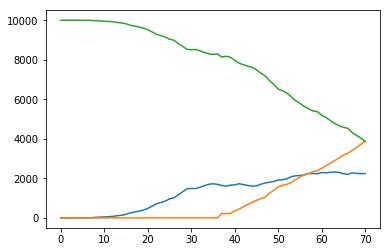

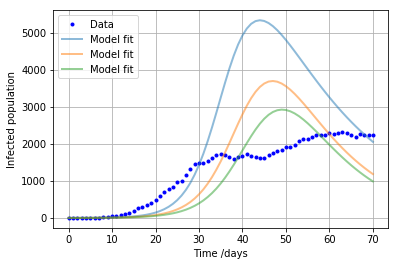

In [416]:
#Getting growth and recovered rate
import scipy.optimize

a0 = .3 #estimation for now
b0 = .05 #estimation for now


R0=Rd[0]   
S0=Sd[0]
I0=Id[0]
t=np.arange(len(utcases))


plt.plot(t,Id,label="Infected")
plt.plot(t,Rd,label="Recovered")
plt.plot(t,Sd,label="Suceptible")


It, at, bt, Niter, dIda, dIdb, St = GaussIter(t, Id, S0, I0, R0, a0, b0)
#params,pcov=curve_fit(It, t, Id, p0=[a0,b0],bounds=([0.0,0.0],[5.0,5.0]))
at, bt, Niter

# UT Model Analysis

Now that we have extracted our growth rate a and recovery rate b, we can apply our findings to a deterministic SIR model.

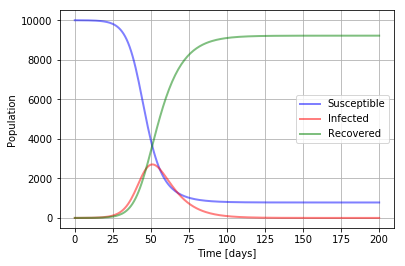

In [417]:
# Total population, N.

I0 = Id[0]
R0 = Rd[0]
S0 = Sd[0]

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
a = at
b = bt

# A grid of time points (in days)
T = 200
dt = 1
Nt = np.int(T/dt)+1
t = np.linspace(0, T, Nt)

# Initial conditions vector
Y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t.
sol = odeint(SIRdot, Y0, t, args=(N, a, b))
S, I, R = sol.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
plt.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')
plt.xlabel('Time [days]')
plt.ylabel('Population')
plt.grid() 
plt.legend()


# Summary

From applying our parameters to the SIR model we can make several obsercations. One being that the peak occurs at day 50. I'm not confident that this is the case because when examining Utah new cases, it seems to be constantly fluctuating with no pattern. Our model suggest the virus will die down around day 100-125. The parameters we extracted was that the growth rate a is around .3 and our recovery rate is about .1. This seems very reasonable. The population is less dense in the area and most people drive which gives less chance of infection between people. 

# Texas Modelling

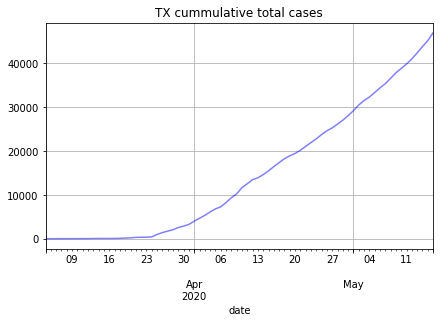

In [400]:
txcases.plot(title="TX cummulative total cases",
            c='b',
            alpha=.5,
            grid=True,
            figsize=(500/72, 300/72))

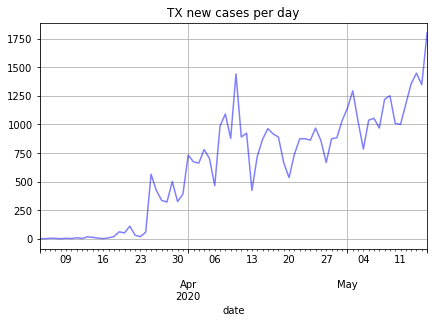

In [401]:
txnew_cases = txcases.diff().fillna(1)   # compute the number of new cases per day:  basically,
                           # new_cases(i) = cases(i)-cases(i-1), and then new_cases(0) = NaN
    

txnew_cases.plot(title="TX new cases per day",
               c='b',
               alpha=.5,
               grid=True,
               figsize=(500/72, 300/72))

# Estimating TX Infected, Susceptible, and Recovered
Here I was able to estimate the number recovered by fitting a sigmoid curve to the recovered population. From here I was able to estimate the susceptible population, and the infected population.


In [431]:
#Setting population and lists for susceptible, infected, and recovered

N=100000

Sd=[]
Id=[]
Rd=[]

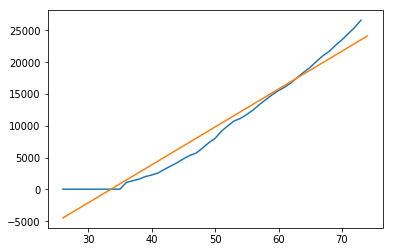

In [432]:
#estimate recovered population using sigmoid curve

#print(txrec[26:])

xdata=np.arange(26,len(txcases))
temp=txrec.values.tolist()
ydata=temp[26:]


#print(len(ydata))
#print(len(xdata))
plt.plot(xdata,ydata)

#plt.plot(xdata,ydata)

coefficients = np.polyfit(xdata, ydata, 1)
poly = np.poly1d(coefficients)

new_x = np.linspace(26,len(txrec))
new_y = poly(new_x)
plt.plot(new_x,new_y)

#print(y)
#rec0=sigmoid(5,*popt)
#print(rec0)


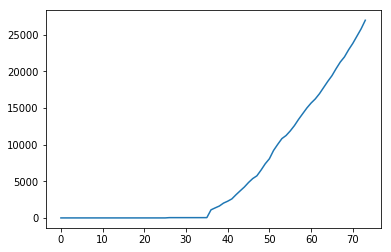

In [433]:
#Get values for estimated recovered and add to Rd as well as calculating in the deaths

prev_vals=np.arange(0,26,1)
rec=poly(prev_vals)
rec=rec.tolist()
#ylist=y.tolist()
#print(ydata)
rec.extend(ydata)
#print(rec)
x=np.arange(len(txcases))
#print(x)

removed=[]

#print(len(nydeathlist))
#print(len(rec))
for i in range(0,len(rec)):
    if rec[i]<0:
        rec[i]=0

for i in range(0,len(rec)):
    removed.append(rec[i]+txdeathlist[i])

#print(rec)
#print(removed)
Rd=rec
plt.plot(x,removed)

In [434]:
activeCases=[]
#estimating infected population
for i in range(len(txnew_cases)):
    if len(activeCases)>14:
        activeCases.pop(0)
        
    activeCases.append(txnew_cases[i])
    Id.append(sum(activeCases))

In [435]:
#Estimating susceptible population

for i in range(0,len(txcases)):
    Sd.append(N-Id[i]-Rd[i])

(0.390336688535058, 0.1793501068782743, 4)

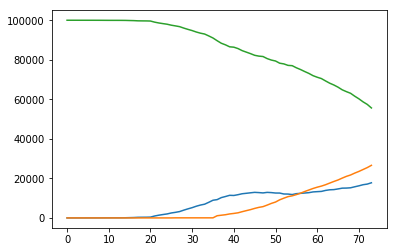

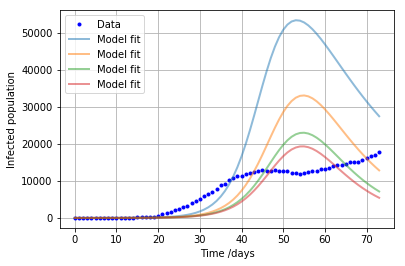

In [436]:
#Getting growth and recovered rate
import scipy.optimize

a0 = .3 #estimation for now
b0 = .05 #estimation for now


R0=Rd[0]   
S0=Sd[0]
I0=Id[0]
t=np.arange(len(txcases))


plt.plot(t,Id,label="Infected")
plt.plot(t,Rd,label="Recovered")
plt.plot(t,Sd,label="Suceptible")


It, at, bt, Niter, dIda, dIdb, St = GaussIter(t, Id, S0, I0, R0, a0, b0)
#params,pcov=curve_fit(It, t, Id, p0=[a0,b0],bounds=([0.0,0.0],[5.0,5.0]))
at, bt, Niter

# TX Model Analysis

Now that we have extracted our growth rate a and recovery rate b, we can apply our findings to a deterministic SIR model.

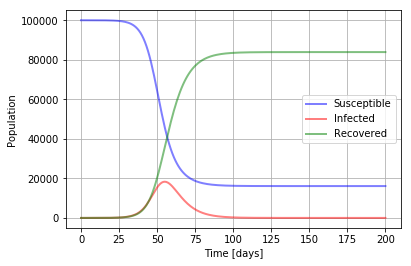

In [437]:
# Total population, N.

I0 = Id[0]
R0 = Rd[0]
S0 = Sd[0]

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
a = at
b = bt

# A grid of time points (in days)
T = 200
dt = 1
Nt = np.int(T/dt)+1
t = np.linspace(0, T, Nt)

# Initial conditions vector
Y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t.
sol = odeint(SIRdot, Y0, t, args=(N, a, b))
S, I, R = sol.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
plt.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')
plt.xlabel('Time [days]')
plt.ylabel('Population')
plt.grid() 
plt.legend()


# Summary

By applying our parameters to the SIR model we can make several observations. One being that the peak occurs around day 50. I found this to be a strange result because Texas has not hit their peak yet. Additonally our growth rate was around .39 and recovery rate around .18 which I did find reasonable.

# Final Remarks
This project helped us apply knowledge from the course and apply them into relevant scenarios. It was fun to be able to model the current epidemic and to make sense out of current events. Further improvements would be to try different ways to find growth and recovery rate, testing other regions, and also seperating deaths and recovery to see how much of the removed population was from deaths or actual recoveries. One of the greatest challenges of this project is dealing with the data. It was hard to collect data but also to make sense out of it. Additionally, some data was incomplete so I had to find methods to try and guess what the data could be at certain times.